# Integrating `Action Graph Service` into `Action` and `ActionObject` Creation

We aim to add an action node whenever an action occurs, or when an action object is created

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService
from syft.service.action.action_graph import InMemoryActionGraphStore
from syft.service.action.action_graph import InMemoryGraphConfig, InMemoryStoreClientConfig
from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
from syft.service.response import SyftError
from syft.types.syft_object import SyftObjectRegistry

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pprint import pprint

print(sy.__version__)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft


Failed to find type for key: __args__ in <class 'typing._UnionGenericAlias'>
Failed to find type for key: _value in <class 'result.result.Err'>
Failed to find type for key: __args__ in <class 'typing._UnionGenericAlias'>
Failed to find type for key: _type_name in <class 'zmq.green.core._Socket'>
Failed to find type for key: value in <enum 'NodeType'>
Failed to find type for key: value in <enum 'ServiceRole'>
Failed to find type for key: value in <enum 'ActionPermission'>
Failed to find type for key: searchable_cks in <class 'syft.store.document_store.StorePartition'>
Failed to find type for key: protocol in <class 'syft.types.grid_url.GridURL'>
Failed to find type for key: value in <enum 'CMPCRUDPermission'>
Failed to find type for key: value in <enum '_ParameterKind'>
Failed to find type for key: _kind in <class 'inspect.Parameter'>
Failed to find type for key: value in <enum 'VPNRoutes'>
Failed to find type for key: value in <enum 'CommandStatus'>
Failed to find type for key: value i

In [2]:
worker = sy.Worker.named(name="test", reset=True, processes=1)
authed_context = AuthedServiceContext(node=worker, 
                                      credentials=worker.signing_key.verify_key)

# node = sy.orchestra.launch(name="test-domain-1", port=8080, dev_mode=True, reset=True)
# domain_client = node.login(email="info@openmined.org", password="changethis")

root_client = worker.root_client
guest_client = worker.guest_client

assert root_client.credentials != guest_client.credentials

action_service = worker.get_service("actionservice")
action_graph_service = worker.get_service("actiongraphservice")
print(action_service.store)
print(action_graph_service.store)

assert isinstance(action_graph_service, ActionGraphService)
assert isinstance(action_graph_service.store, InMemoryActionGraphStore)

SQLite Store Path:
!open file:///tmp/9f86d081884c4d659a2feaa0c55ad015.sqlite



## Action / Action Object Creation

#### There are 2 places where we add a new `action_object`:
    - when we upload a new dataset
    - when someone send a piece of data to us

#### First scenario: Create and upload a dataset

In [3]:
num_assets = 2

In [4]:
dataset = sy.Dataset(name="Test Dataset")
dataset.set_description("""Test Dataset""")
dataset.add_citation("Person, place or thing")

country = sy.DataSubject(name="Country", aliases=["country_code"])
canada = sy.DataSubject(name="Canada", aliases=["country_code:ca"])
country.add_member(canada)
registry = root_client.data_subject_registry
response = registry.add_data_subject(country)

for i in range(num_assets):
    data = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))
    mock = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))

    ctf = sy.Asset(name=f"test_dataset_{i}")
    ctf.set_description("""all the datas""")
    ctf.set_obj(data)
    ctf.set_shape((10, 4))
    ctf.add_data_subject(canada)
    ctf.set_mock(mock, mock_is_real=False)
    dataset.add_asset(ctf)

In [5]:
root_client.upload_dataset(dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.57it/s]


Uploading: test_dataset_0
Uploading: test_dataset_1


<class 'syft.service.response.SyftSuccess'>: Dataset Added

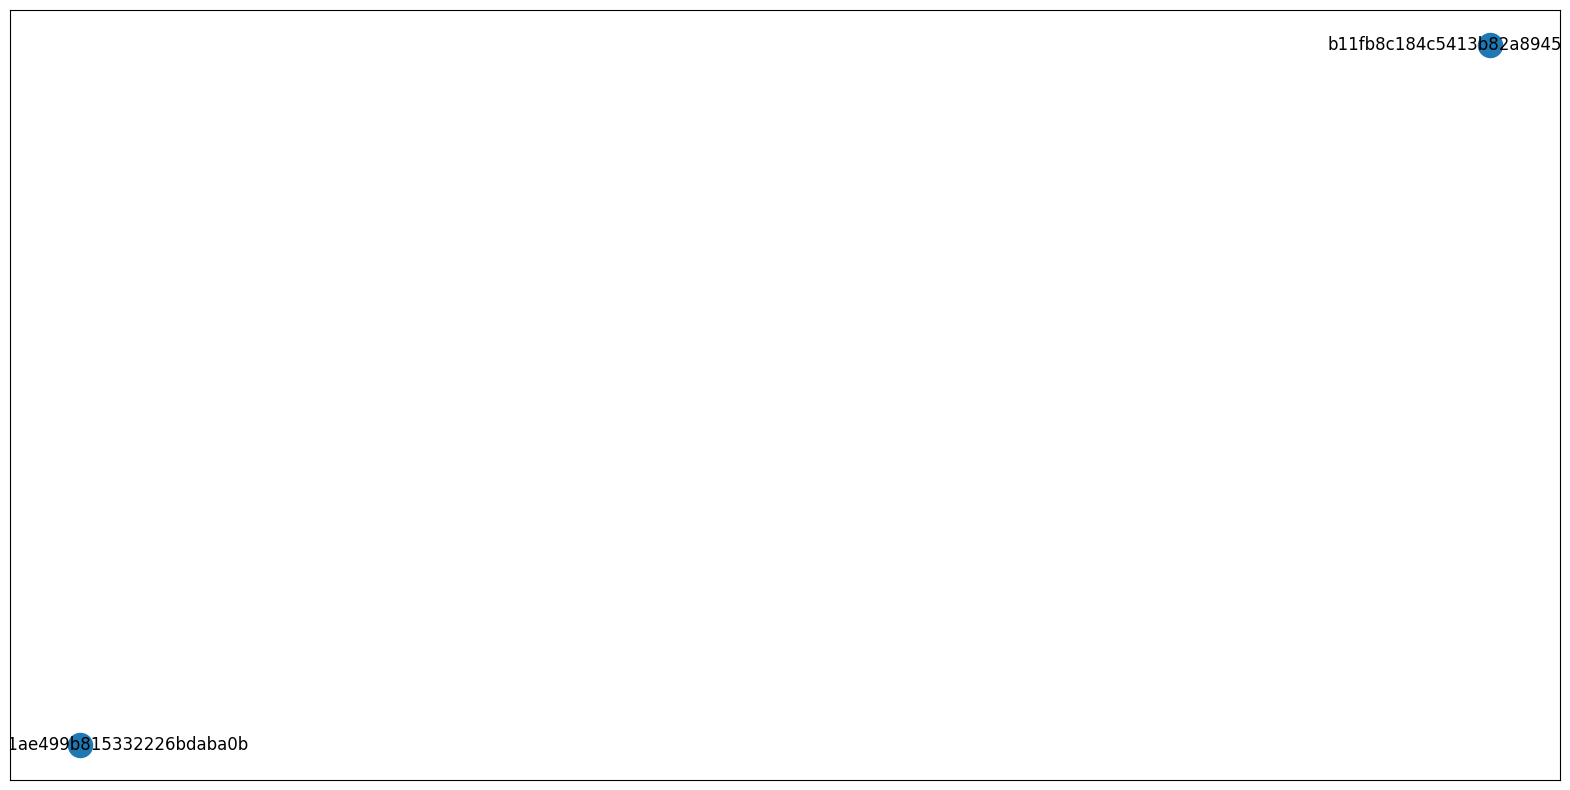

In [6]:
action_graph_service.visualize(context=authed_context)

In [7]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 2: Create a node when `action_obj.send` method is called

In [8]:
action_obj_a = ActionObject.from_obj([2, 4, 6])

In [9]:
action_obj_a.send(root_client)

Pointer:
[2, 4, 6]

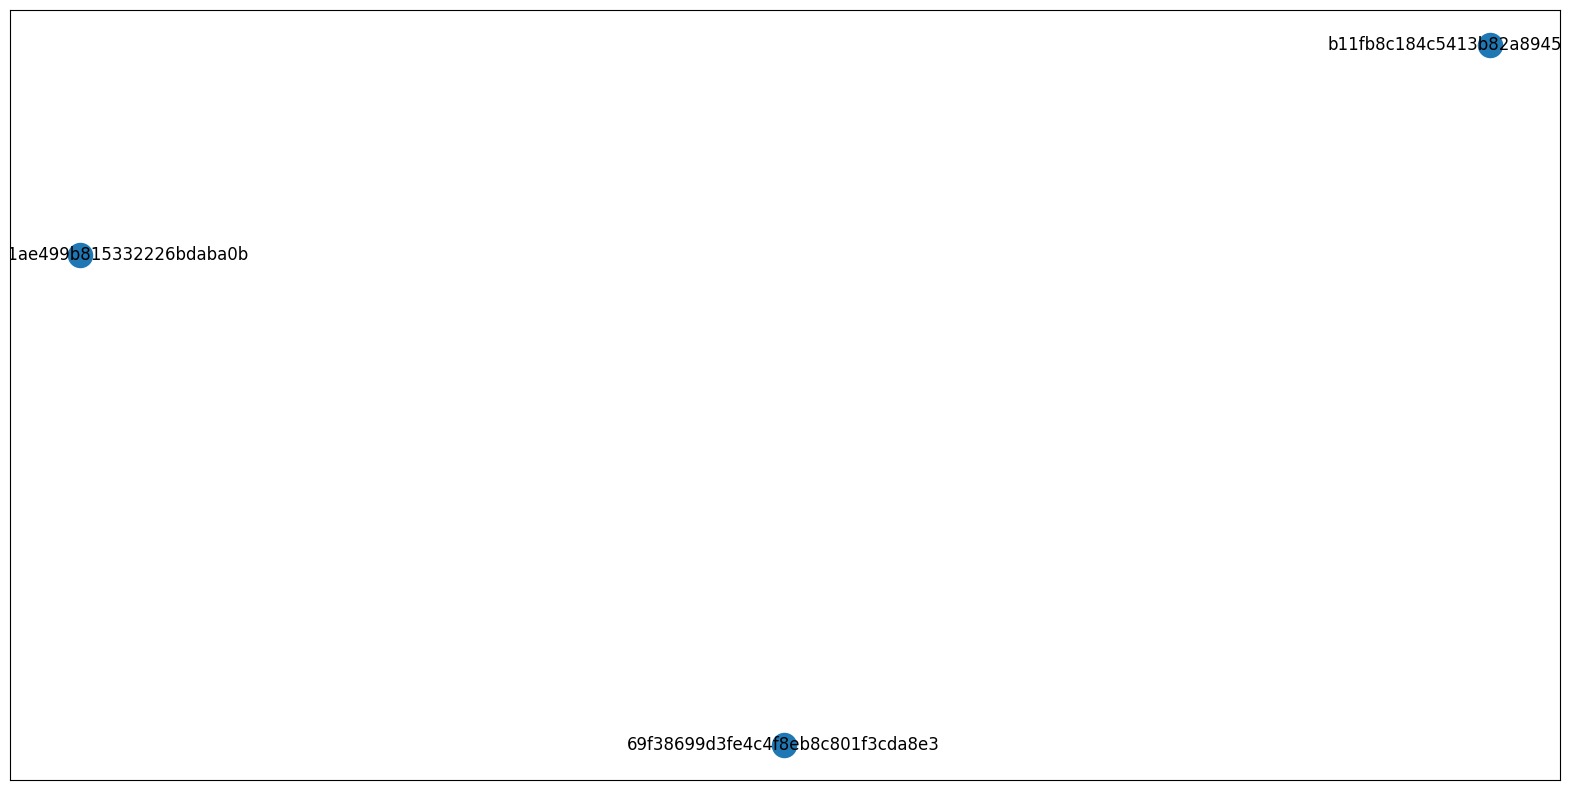

In [10]:
action_graph_service.visualize(context=authed_context)

In [11]:
assert action_graph_service.get(action_obj_a.id, authed_context).id == action_obj_a.id

In [12]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets + 1
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 3: Create a graph node when an `Action` is created in `generate_remote_lib_function` in `packages/syft/src/syft/client/api.py`

New worker with a different database and in-memory graph

In [9]:
worker2 = sy.Worker.named(name="test2", processes=1, reset=True)

action_service2 = worker2.get_service("actionservice")
action_graph_service2 = worker2.get_service("actiongraphservice")

SQLite Store Path:
!open file:///tmp/60303ae22b994861bce3b28f33eec1be.sqlite



In [10]:
b = worker2.root_client.api.lib.numpy.array([1,2,3])

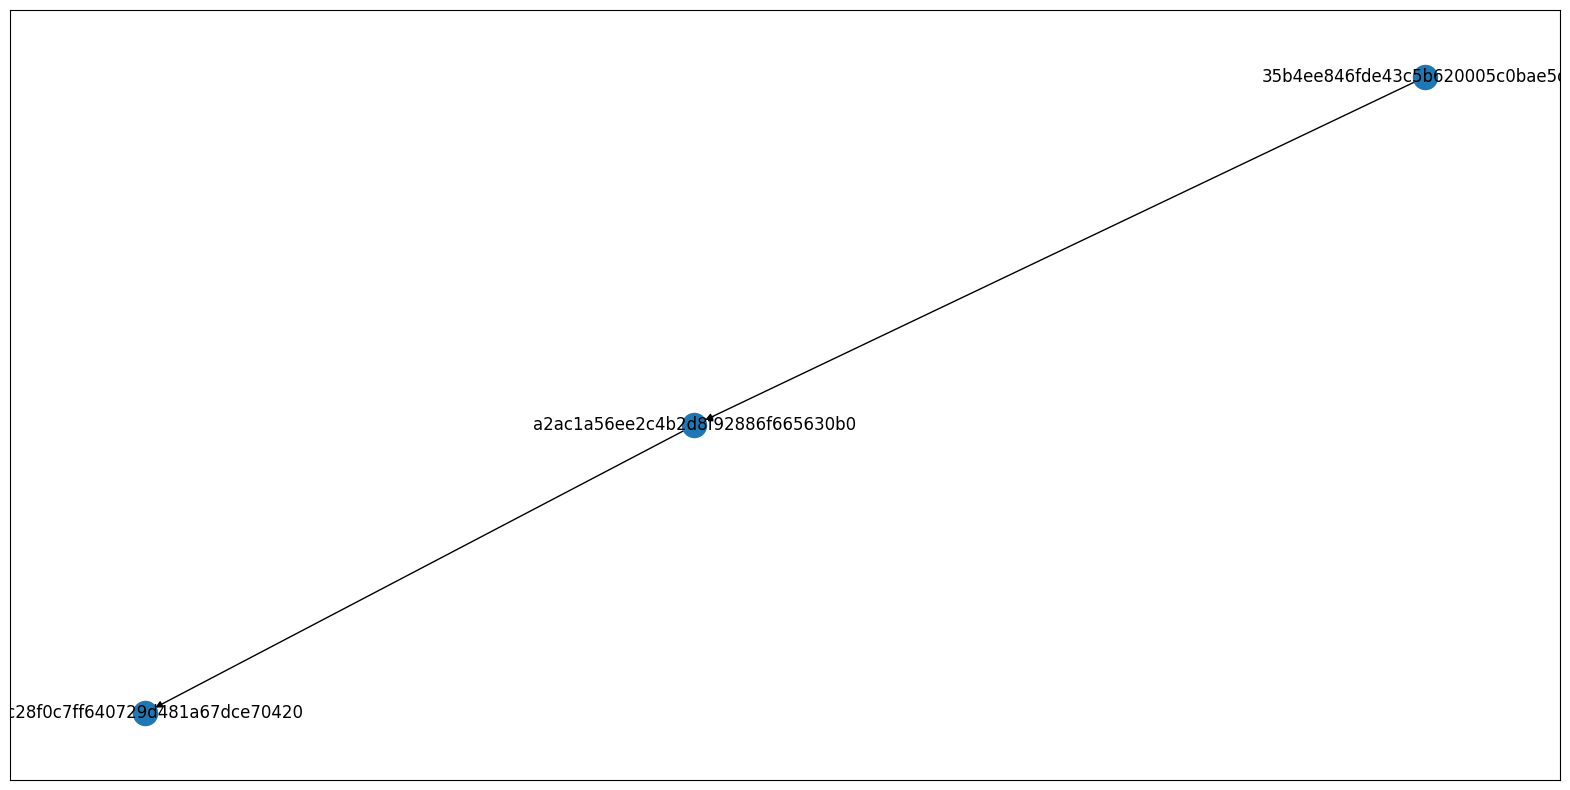

In [11]:
action_graph_service2.visualize(context=authed_context)

In [12]:
assert len(action_graph_service2.get_all_nodes(authed_context)) == 3
assert len(action_graph_service2.get_all_edges(authed_context)) == 2

In [13]:
worker2.action_store.data

{<UID: 35b4ee846fde43c5b620005c0bae5d47>: Pointer:
[1, 2, 3], <UID: 16c28f0c7ff640729d481a67dce70420>: Pointer:
[1 2 3]}

In [14]:
list(worker2.action_graph_store.graph.db.nodes)

,type,id
0,<UID: 35b4ee846fde43c5b620005c0bae5d47>,35b4ee846fde43c5b620005c0bae5d47
1,<UID: a2ac1a56ee2c4b2d8f92886f665630b0>,a2ac1a56ee2c4b2d8f92886f665630b0
2,<UID: 16c28f0c7ff640729d481a67dce70420>,16c28f0c7ff640729d481a67dce70420


In [15]:
c = worker2.guest_client.api.lib.numpy.array([2,3,4])

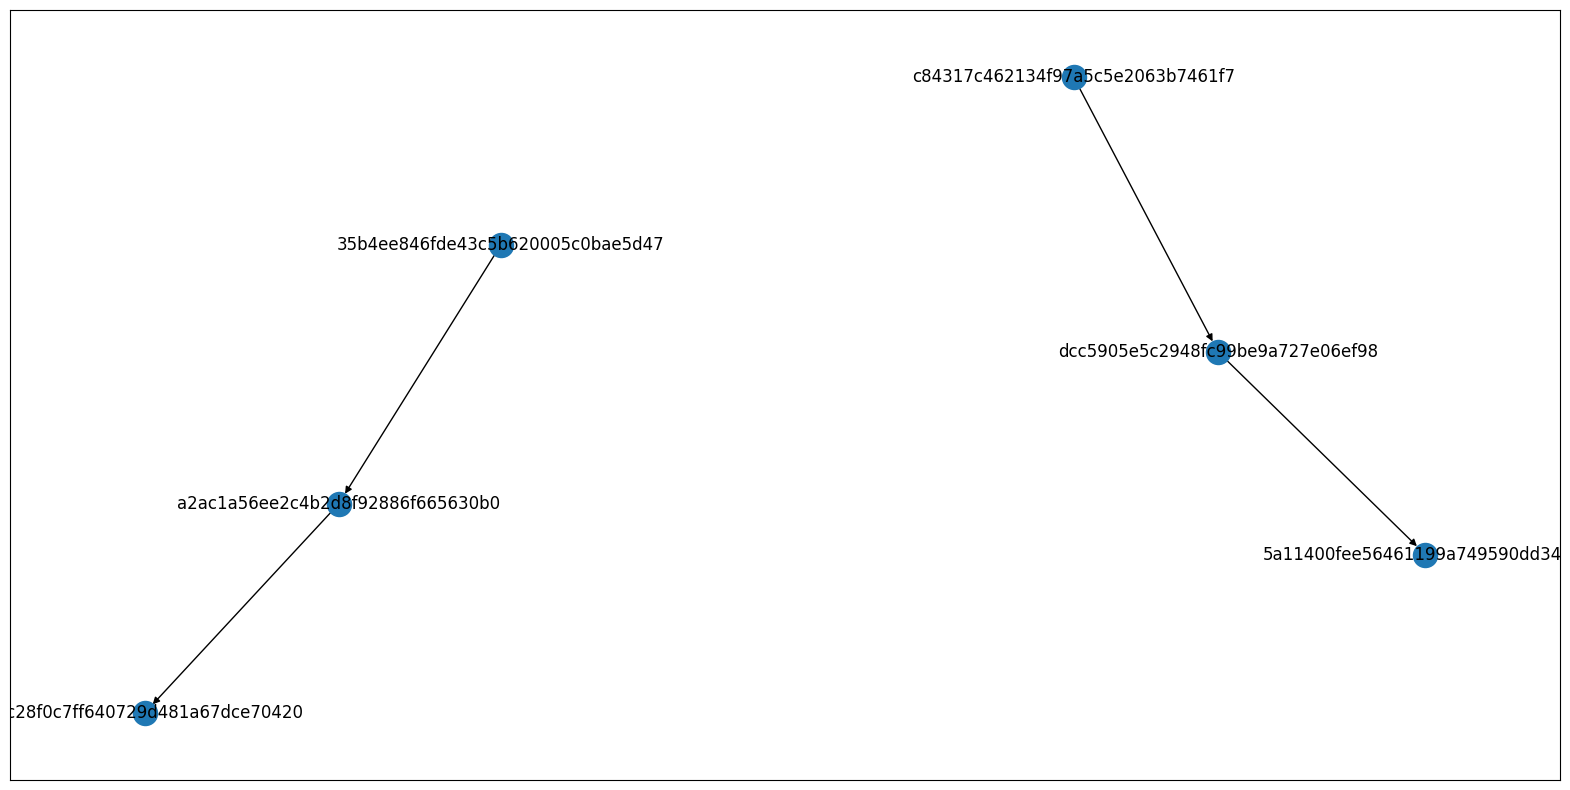

In [16]:
action_graph_service2.visualize(context=authed_context)

In [18]:
assert len(action_graph_service2.get_all_nodes(authed_context)) == 6
assert len(action_graph_service2.get_all_edges(authed_context)) == 4

In [20]:
e = worker2.guest_client.api.lib.numpy.add(c, b)

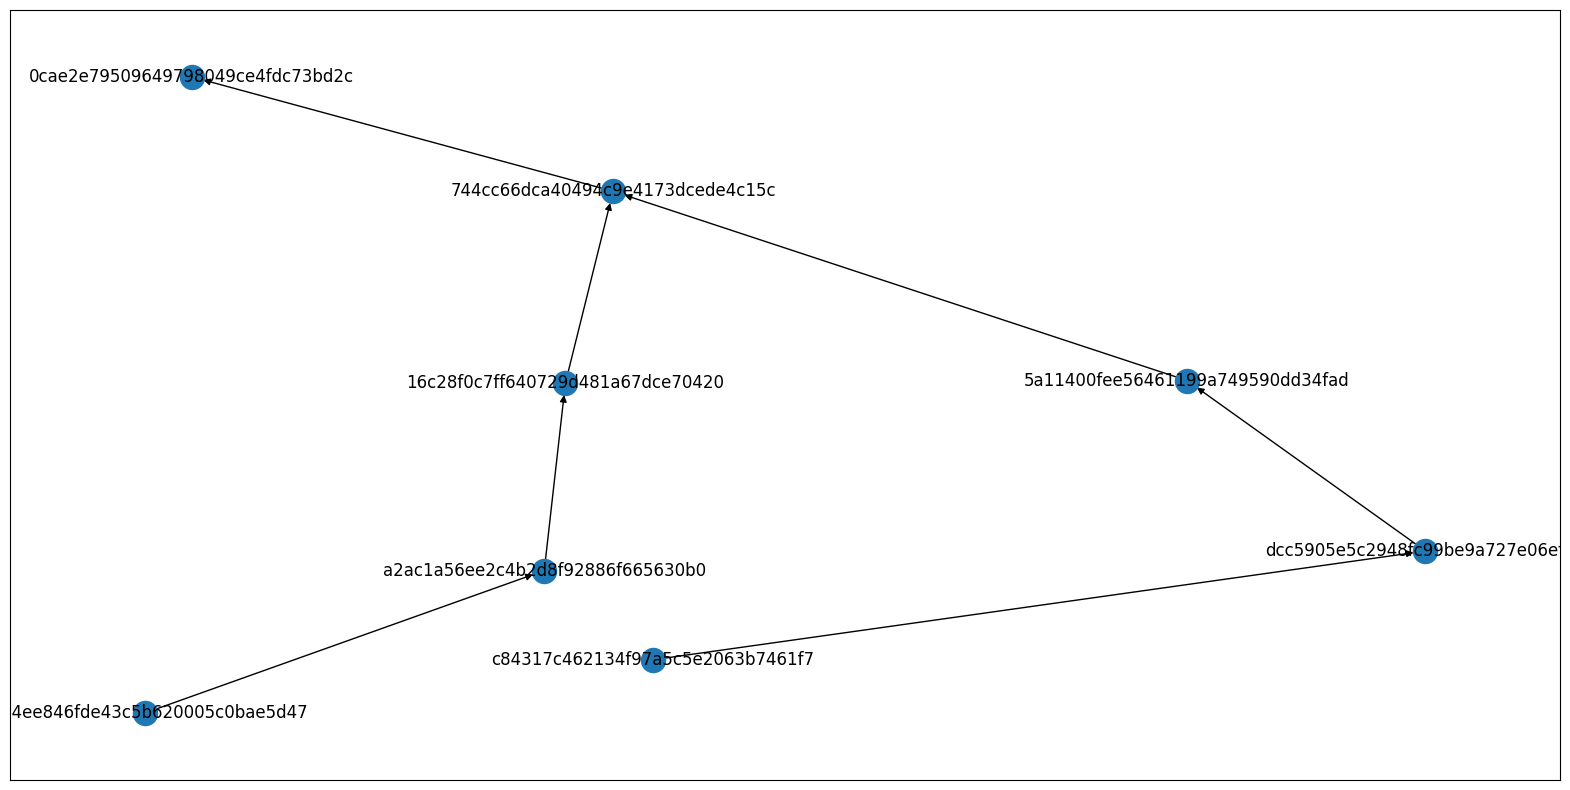

In [21]:
action_graph_service2.visualize(context=authed_context)

In [22]:
assert len(action_graph_service2.get_all_nodes(authed_context)) == 8
assert len(action_graph_service2.get_all_edges(authed_context)) == 7

#### Scenario 4: Create a graph node when an Action is created in the `syft_make_action` method of `ActionObject`

In [23]:
worker3 = sy.Worker.named(name="test3", processes=1, reset=True)

action_service3 = worker3.get_service("actionservice")
action_graph_service3 = worker3.get_service("actiongraphservice")
root_client3 = worker3.root_client
guest_client3 = worker3.guest_client
authed_context = AuthedServiceContext(node=worker3, 
                                      credentials=worker3.signing_key.verify_key)

worker3

SQLite Store Path:
!open file:///tmp/fd61a03af4f74d878fc21e05e7e80678.sqlite



Worker: test3 - fd61a03af4f74d878fc21e05e7e80678 - NodeType.DOMAIN

Services:
ActionGraphService, ActionService, DataSubjectMemberService, DataSubjectService, DatasetService, MessageService, NetworkService, PolicyService, ProjectService, RequestService, SettingsService, UserCodeService, UserService

In [24]:
a = root_client3.api.lib.numpy.array([1,2,3])
# b = guest_client3.api.lib.numpy.array([1,2,3])

In [25]:
c = ActionObject.from_obj(2)

In [26]:
a*c

```python
Pointer
```
array([2, 4, 6])

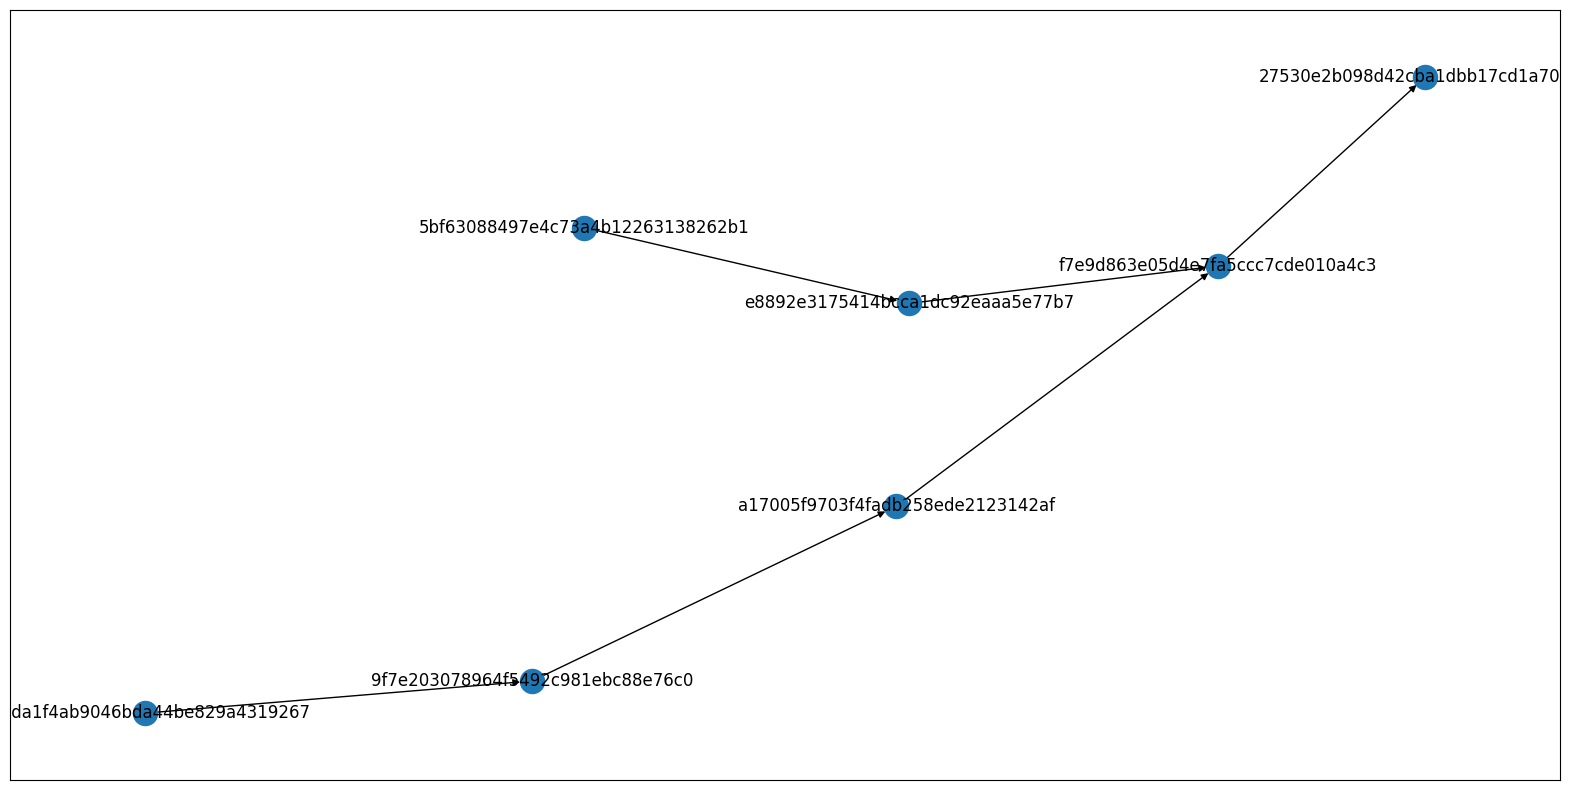

In [27]:
action_graph_service3.visualize(authed_context)

In [28]:
assert len(action_service3.store.data) == 4

In [29]:
assert len(action_graph_service3.get_all_nodes(authed_context))==7
assert len(action_graph_service3.get_all_edges(authed_context))==6

#### Reproducing error in `test_actionobject_syft_make_action`

```python
def test_actionobject_syft_make_action(worker, testcase):
    orig_obj, op, args, kwargs = testcase

    obj = helper_make_action_obj(orig_obj)
    obj_pointer, args_pointers, kwargs_pointers = helper_make_action_pointers(
        worker, obj, *args, **kwargs
    )

    path = str(type(orig_obj))
    action = obj.syft_make_action(path, op, args=args_pointers, kwargs=kwargs_pointers)

    assert action.full_path.endswith("." + op)
```
The reason is that we call `obj.syft_make_action` instead of `obj_pointer.syft_make_action`, and `obj` does not have a `syft_node_uid`, hence we can't get the action graph service api for it. 

In [2]:
worker4 = sy.Worker.named(name="test4", processes=1, reset=True)

action_service4 = worker4.get_service("actionservice")
action_graph_service4 = worker4.get_service("actiongraphservice")
root_client4 = worker4.root_client
guest_client4 = worker4.guest_client
authed_context = AuthedServiceContext(node=worker4, 
                                      credentials=worker4.signing_key.verify_key)
worker4

SQLite Store Path:
!open file:///tmp/a4e624d686e04ed2b67c0abd85c14426.sqlite



Worker: test4 - a4e624d686e04ed2b67c0abd85c14426 - NodeType.DOMAIN

Services:
ActionGraphService, ActionService, DataSubjectMemberService, DataSubjectService, DatasetService, MessageService, NetworkService, PolicyService, ProjectService, RequestService, SettingsService, UserCodeService, UserService

In [3]:
def helper_make_action_obj(orig_obj):
    obj_id = Action.make_id(None)
    lin_obj_id = Action.make_result_id(obj_id)

    return ActionObject.from_obj(orig_obj, id=obj_id, syft_lineage_id=lin_obj_id)


def helper_make_action_pointers(worker, obj, *args, **kwargs):
    root_domain_client = worker.root_client
    root_domain_client.api.services.action.set(obj)
    obj_pointer = root_domain_client.api.services.action.get_pointer(obj.id)
#     obj.syft_node_uid = obj_pointer.syft_node_uid

    # The args and kwargs should automatically be pointerized by obj_pointer
    return obj_pointer, args, kwargs

In [4]:
orig_obj, op, args, kwargs = (int(1), "__add__", [1], {})
obj = helper_make_action_obj(orig_obj)
obj_pointer, args_pointers, kwargs_pointers = helper_make_action_pointers(
        worker4, obj, *args, **kwargs
)
path = str(type(orig_obj))

In [5]:
action = obj.syft_make_action(path, op, args=args_pointers, kwargs=kwargs_pointers)

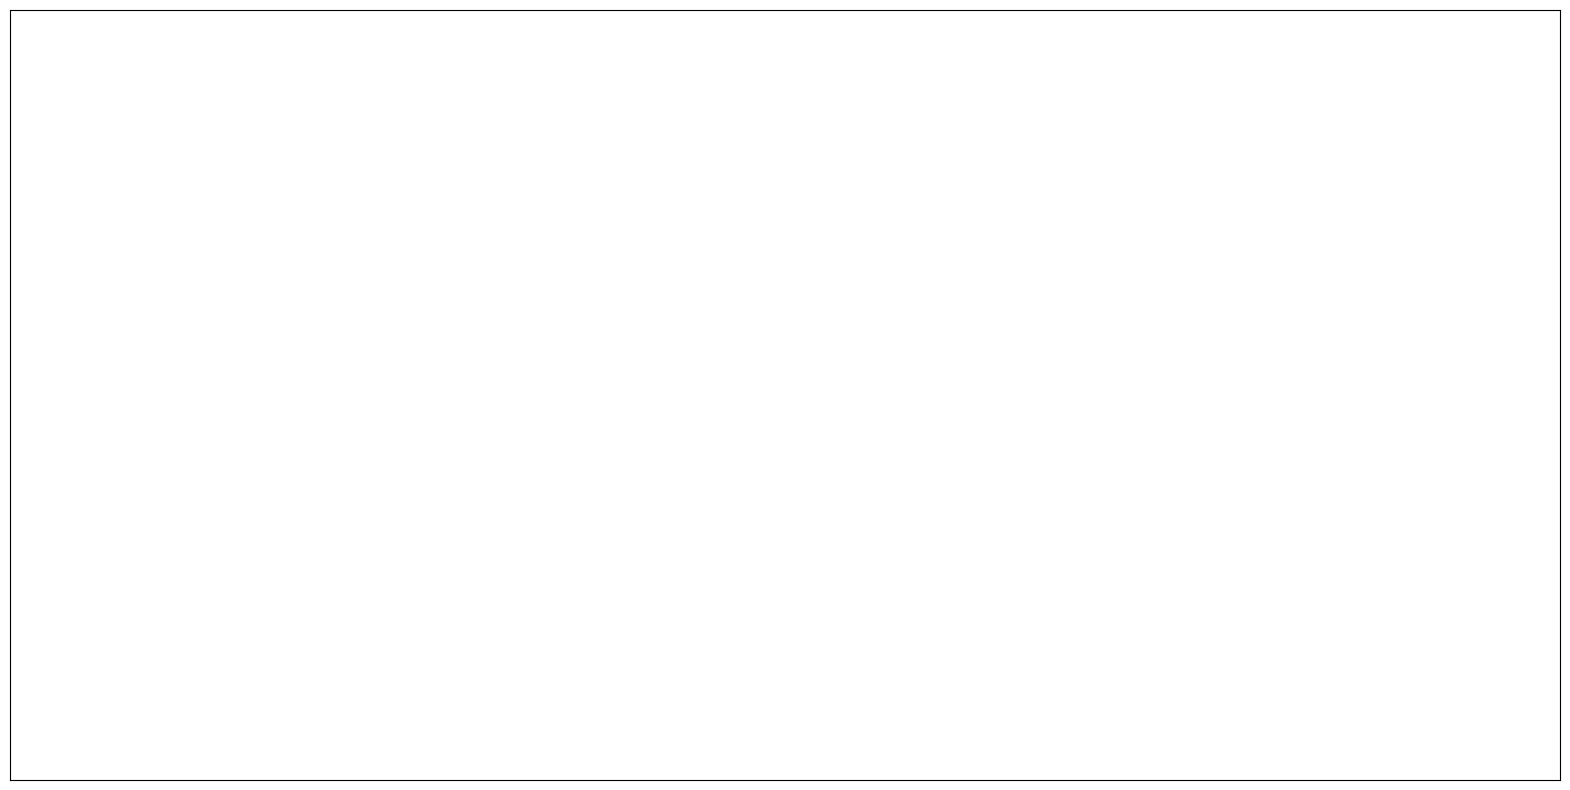

In [6]:
action_graph_service4.visualize(authed_context)

In [9]:
assert len(action_graph_service4.get_all_nodes(authed_context)) == 0